In [73]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import r2_score

# start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
# end_date = datetime(2023, 11, 28, 15, 59, 59).replace(tzinfo=timezone.utc)
# system_ids = [18]

start_date = datetime(2023, 12, 22, 15, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 12, 30, 23, 59, 59).replace(tzinfo=timezone.utc)
system_ids = [10,12,16,18,20]
#system_ids = [18]

filter = '1h'

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")


In [74]:
def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)

In [75]:
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

# Perform RANSAC only on slope and then select valid calibrations

In [76]:
# if filter == "1h":
#     df_p = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
#         .filter(pl.col("creation_timestamp").is_between(start_date, end_date))
# if filter == "10m":
#     df_p = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet")) \
#         .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [77]:
def fit_ransac(x, y, date):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)
    T = np.array(date)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.02)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

In [78]:
df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-12").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp
date,str,f64,f64,"datetime[μs, UTC]",f64
2023-12-23,"""tum-esm-midcos…",1.027195,3.588909,2023-12-23 02:21:29.740 UTC,473138.358261
2023-12-24,"""tum-esm-midcos…",1.025923,4.069319,2023-12-24 03:20:11.800 UTC,473163.336611
2023-12-25,"""tum-esm-midcos…",1.023164,6.097302,2023-12-25 04:30:16.470 UTC,473188.504575
2023-12-26,"""tum-esm-midcos…",1.025081,5.027209,2023-12-26 05:48:16.220 UTC,473213.804506
2023-12-27,"""tum-esm-midcos…",1.064069,-14.31654,2023-12-27 06:25:05.720 UTC,473238.418256
2023-12-28,"""tum-esm-midcos…",1.030924,2.526298,2023-12-28 07:22:03.960 UTC,473263.367767


`min_samples` may not be larger than number of samples: n_samples = 1.
Could not find calibrations for system 10


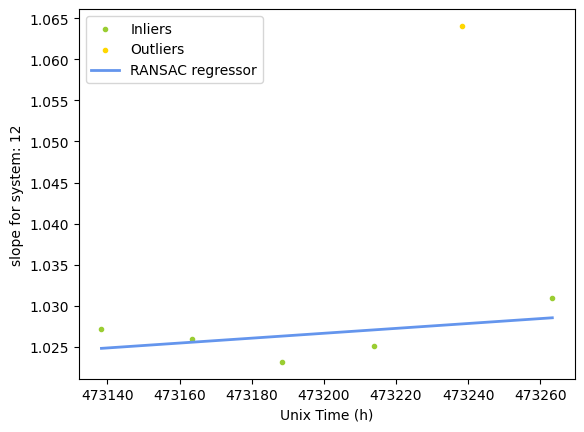

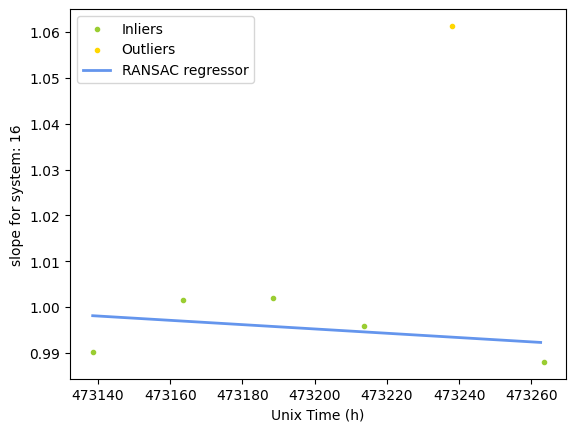

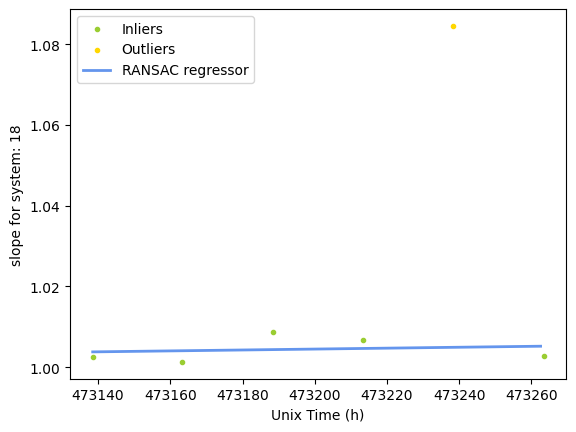

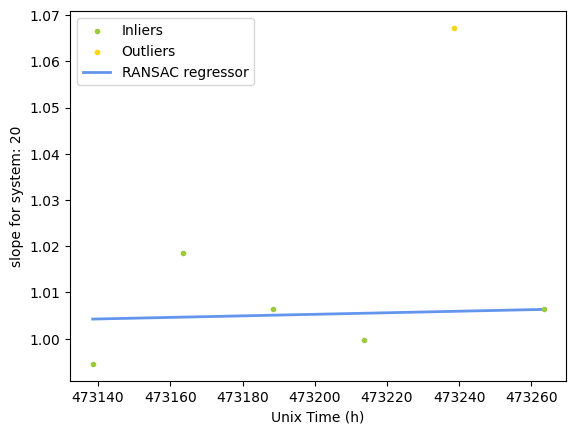

In [79]:
l_df_cor = []

for id in system_ids:
    try:
        df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

        y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
        x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()
        d = df_sys.select(pl.col("creation_timestamp")).collect().to_series().to_list()
        mask = fit_ransac(x,y,d)

        df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
        
        l_df_cor.append(df_sys)
    except Exception as e:
        print(e)
        print(f"Could not find calibrations for system {id}")
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [80]:
df_cal_ransac = df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .filter(pl.col("mask") == True) \
    .sort("creation_timestamp") \
    .lazy()
    
df_cal_ransac.head(3).collect()

date,system_name,slope,intercept,creation_timestamp,timestamp,mask,ransac_slope,ransac_intercept
date,str,f64,f64,"datetime[μs, UTC]",f64,bool,f64,f64
2023-12-23,"""tum-esm-midcos…",1.027195,3.588909,2023-12-23 02:21:29.740 UTC,473138.358261,true,1.027195,3.588909
2023-12-23,"""tum-esm-midcos…",0.994526,-7.130625,2023-12-23 02:31:21.470 UTC,473138.522631,true,0.994526,-7.130625
2023-12-23,"""tum-esm-midcos…",1.00255,-1.302809,2023-12-23 02:31:24.520 UTC,473138.523478,true,1.00255,-1.302809


In [81]:
df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [82]:
df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_1h]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='1h')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_1h = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_1h.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))


In [83]:
df_p_10m = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet")) \
        .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# reduce timestamp to date DD.XX.YYYY for measurement dataset and join slope and intercept from df_cal
df_date = df_dry.filter(pl.col("gmp343_dry") > 0) \
    .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
    .join(df_cal_ransac, on = ["date","system_name"], how= "left")

        
l_df_cal_corr =[df_p_10m]

for id in system_ids:  
    # broadcast: via backward and forward fill
    # calibration correction: via coloumn operation 
    # aggregation: defined by filter
    # offset calculation to reference instrument PICARRO
    df_cal_corr = df_date.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
    .fill_null(strategy = "backward") \
    .fill_null(strategy = "forward") \
    .with_columns(((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .sort("creation_timestamp") \
    .groupby_dynamic("creation_timestamp", every='10m')  \
    .agg([
        pl.all().exclude(["creation_timestamp","system_name"]).mean(),
        pl.col("system_name")
        ]) \
    .with_columns(pl.col("system_name").list.last()) \
    .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_10m.select("creation_timestamp", "CO2_corr") \
                .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
                .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
                .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)
        
    
df_cal_corr_agg_10m = pl.concat(l_df_cal_corr, how="diagonal")
df_cal_corr_agg_10m.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "10m_cal_corr_acropolis.parquet"))


In [84]:
import plotly.express as px

fig = px.line(df_cal_corr_agg_1h, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2 Dry", color="system_name")
fig.show()

fig = px.line(df_cal_corr_agg_1h, x="creation_timestamp", y=f"diff", markers=True, title = "Difference Acropolis System - PICARRO", color="system_name")
fig.show()

In [85]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 10:

Analysis for System 12:
Offset -0.1784248218448501
RMSE: 0.45729000191110925
R2: 0.9978308144553488

Analysis for System 16:
Offset 0.030651061045633643
RMSE: 0.6750195998218309
R2: 0.9952734304188975

Analysis for System 18:
Offset -0.16645040276391754
RMSE: 0.6186320981389704
R2: 0.9960301125969667

Analysis for System 20:
Offset -0.1965178193672319
RMSE: 0.6935308456098914
R2: 0.9950106398670016


# Substract mean offset

In [86]:
for system_id in system_ids:

    print(f"\nAnalysis for System {system_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_corr_agg_1h.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{system_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{system_id}"})
        
    df_picarro = df_cal_corr_agg_1h.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{system_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{system_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 10:

Analysis for System 12:
RMSE: 0.45729000191110925
R2: 0.9978308144553488

Analysis for System 16:
RMSE: 0.674323344249924
R2: 0.9952831759231524

Analysis for System 18:
RMSE: 0.5958187109075664
R2: 0.9963175100996567

Analysis for System 20:
RMSE: 0.6651058415647234
R2: 0.9954112456018576
